# Forecast Model Analysis
Trying some different models to predict weight.

In [1]:
import functions as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
os.chdir('..')
from utils.weight_analysis import wana
analysis = wana('data/weight.csv')
os.chdir('forecast_model')

### Checking the Data

In [2]:
analysis.raw_df

,date,weight_lbs,exer,food,avg_7d
date,,,,,
2024-11-19,2024-11-19,160.4,1,5,160.00
2024-11-20,2024-11-20,159.2,1,6,160.00
2024-11-21,2024-11-21,159.0,0,5,160.03
2024-11-22,2024-11-22,159.2,1,6,159.86
2024-11-23,2024-11-23,159.0,0,5,159.66
...,...,...,...,...,...
2025-06-05,2025-06-05,156.6,1,4,NaN
2025-06-06,2025-06-06,156.0,0,4,NaN
2025-06-07,2025-06-07,154.6,0,5,NaN


In [3]:
analysis.df

,weight_lbs,exer,food,weight_lbs_avg_7d,food_avg_7d,exer_avg_7d,food_exercise_avg_7d
date,,,,,,,
2024-11-19,160.4,1,5,NaN,NaN,NaN,NaN
2024-11-20,159.2,1,6,NaN,NaN,NaN,NaN
2024-11-21,159.0,0,5,NaN,NaN,NaN,NaN
2024-11-22,159.2,1,6,NaN,NaN,NaN,NaN
2024-11-23,159.0,0,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-05,156.6,1,4,156.457143,0.424242,0.833333,0.628788
2025-06-06,156.0,0,4,156.457143,0.424242,0.833333,0.628788
2025-06-07,154.6,0,5,156.342857,0.424242,0.666667,0.545455


## ARIMA Model
SARIMAX(2,1,2) with food_exercise_avg_7d as x

In [4]:
no_miss = analysis.df.dropna()[['weight_lbs', 'food_exercise_avg_7d']]
no_miss

,weight_lbs,food_exercise_avg_7d
date,,
2024-11-25,158.8,0.651515
2024-11-26,159.0,0.651515
2024-11-27,159.0,0.553030
2024-11-28,157.0,0.651515
2024-11-29,161.0,0.590909
...,...,...
2025-06-05,156.6,0.628788
2025-06-06,156.0,0.628788
2025-06-07,154.6,0.545455


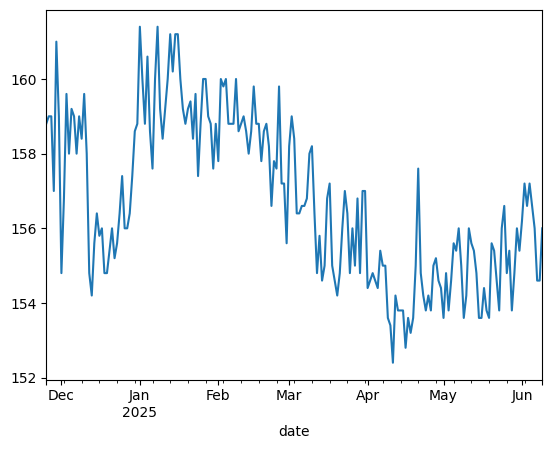

In [5]:
y = no_miss['weight_lbs']
x = no_miss['food_exercise_avg_7d']
y.plot()
plt.show()

In [6]:
sf.stationarity_test(y)

('Non-Stationarity', 'Non-Stationarity')

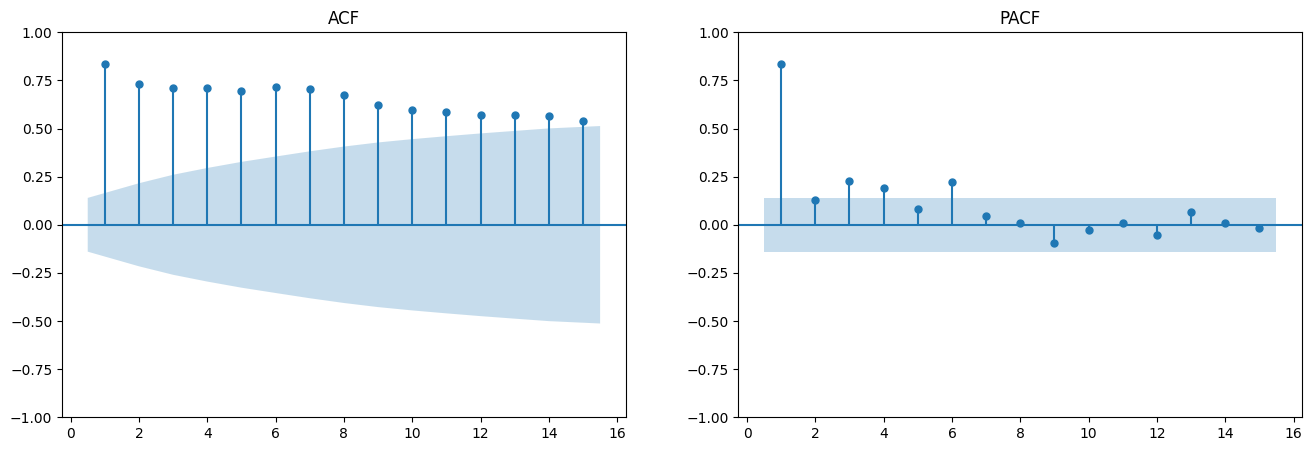

In [7]:
sf.all_ac(y)

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             weight_lbs   No. Observations:                  197
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -294.545
Date:                Mon, 09 Jun 2025   AIC                            601.090
Time:                        09:34:18   BIC                            620.759
Sample:                    11-25-2024   HQIC                           609.053
                         - 06-09-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
food_exercise_avg_7d    -2.0124      0.781     -2.578      0.010      -3.542      -0.483
ar.L1                    0.9142      0.340      2.691      0.007       0.248       1.580
ar.L2       

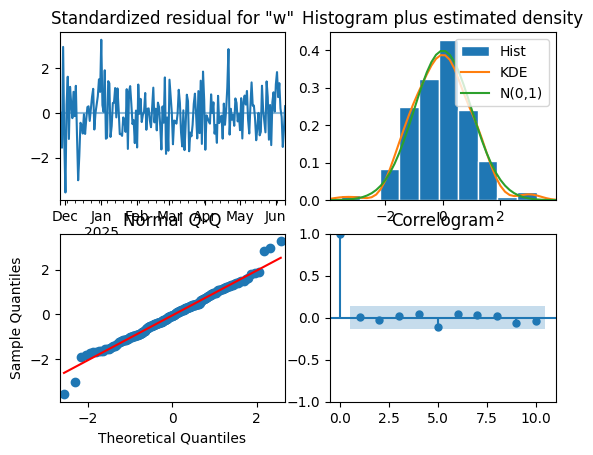

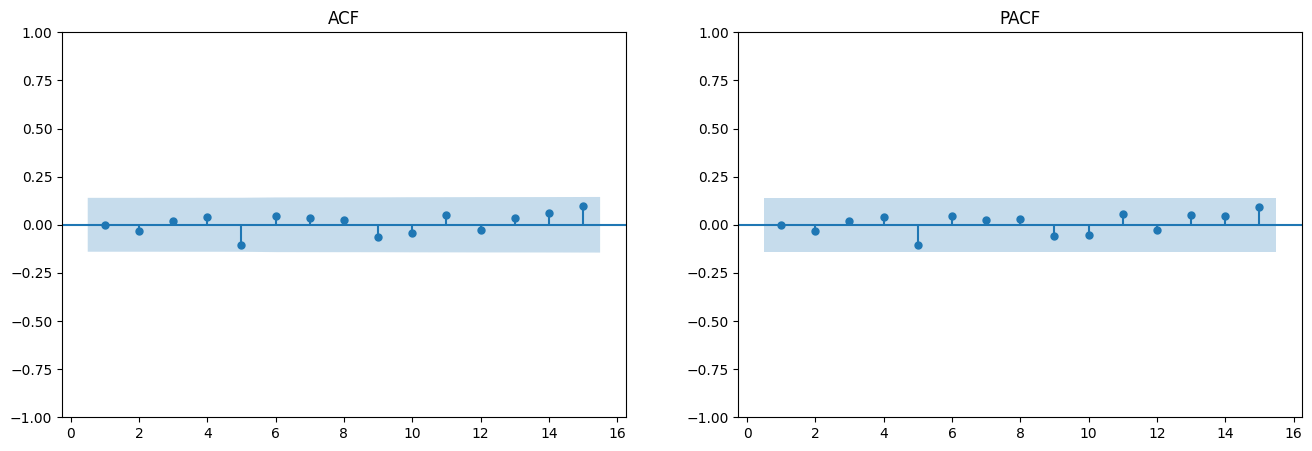

In [8]:
model1 = SARIMAX(y, order=(2,1,2), exog=x).fit(disp=False)
sf.diagnostic(model1)

In [9]:
future_steps = 14
x_bad = np.full(future_steps, 0.25)
x_good = np.full(future_steps, 0.75)
prediction_bad = model1.get_forecast(steps=future_steps, exog=x_bad).predicted_mean
prediction_good = model1.get_forecast(steps=future_steps, exog=x_good).predicted_mean

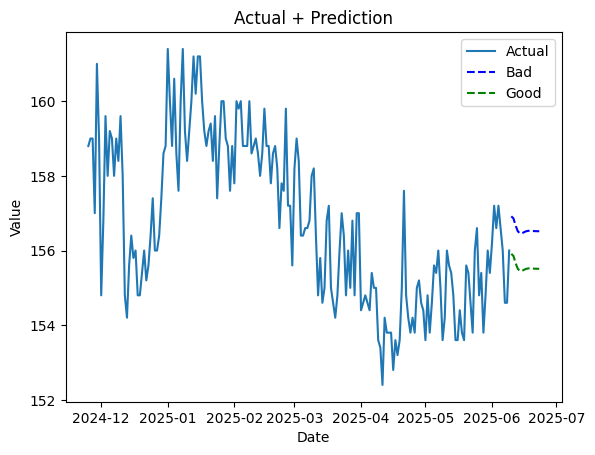

In [10]:
sf.compare_predictions(y,[prediction_bad,prediction_good],['Bad','Good'])

In [11]:
model_params = {
    "params": model1.params.to_dict(),
    "order": (2, 1, 2),
    "exog_mean": x.mean(),
    "exog_std": x.std()
}

with open('model_parameters_arima.json', 'w') as f:
    json.dump(model_params, f)

If we need to implement the model we could use:

In [12]:
# with open('model_parameters_arima.json', 'r') as f:
#     model_params = json.load(f)

## Second Model: Weekly gains regressed by food and exericise

In [13]:
df = analysis.df[['weight_lbs_avg_7d', 'exer', 'food']].dropna()
df

,weight_lbs_avg_7d,exer,food
date,,,
2024-11-25,159.228571,1,2
2024-11-26,159.028571,1,5
2024-11-27,159.000000,0,5
2024-11-28,158.714286,1,6
2024-11-29,158.971429,1,2
...,...,...,...
2025-06-05,156.457143,1,4
2025-06-06,156.457143,0,4
2025-06-07,156.342857,0,5


In [14]:
weekly_df = analysis.df.resample('W').agg({'weight_lbs_avg_7d': 'last','exer': 'sum','food': 'mean'})
weekly_df['y'] = weekly_df['weight_lbs_avg_7d'].diff()
weekly_df = weekly_df.dropna()
weekly_df = weekly_df[weekly_df['exer']<7]
weekly_df

,weight_lbs_avg_7d,exer,food,y
date,,,,
2024-12-08,158.514286,5,5.000000,0.142857
2024-12-15,156.714286,5,5.428571,-1.800000
2024-12-22,155.428571,6,6.142857,-1.285714
2024-12-29,156.457143,5,3.571429,1.028571
2025-01-12,159.400000,6,2.857143,-0.142857
2025-01-19,160.257143,2,3.285714,0.857143
2025-01-26,158.971429,6,5.142857,-1.285714
2025-02-02,158.857143,1,4.142857,-0.114286
2025-02-09,159.257143,4,4.000000,0.400000


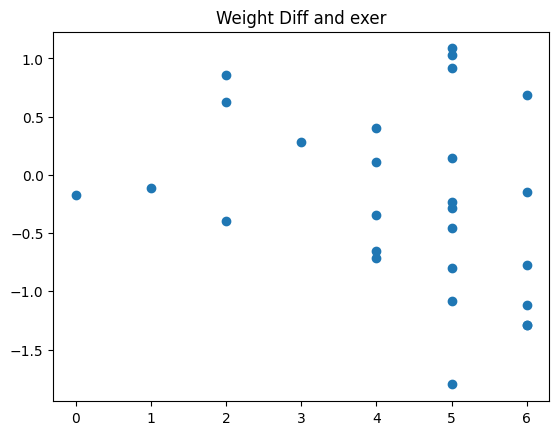

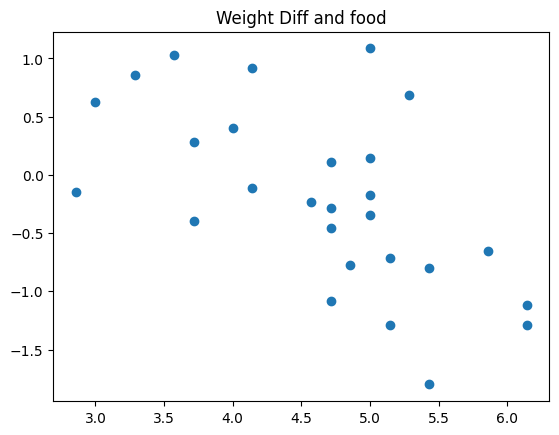

In [15]:
for x in ['exer', 'food']:
    plt.scatter(weekly_df[x],weekly_df['y'])
    plt.title(f'Weight Diff and {x}')
    plt.show()

I will use a Partial Least Squares (PLS) approach because I want to capture a combined effect of food and exercise. First, I’ll identify a linear combination of the two variables that maximizes their covariance with weekly weight changes. Then, for simplicity and ease of implementation, I’ll use this combined factor as the predictor in a straightforward linear regression model.

In [16]:
food_min = weekly_df['food'].min()
food_max = weekly_df['food'].max()
food_range = food_max - food_min

exer_min = weekly_df['exer'].min()
exer_max = weekly_df['exer'].max()
exer_range = exer_max - exer_min

weekly_df['food'] = (weekly_df['food'] - food_min)/food_range
weekly_df['exer'] = (weekly_df['exer'] - exer_min)/exer_range

weekly_df


,weight_lbs_avg_7d,exer,food,y
date,,,,
2024-12-08,158.514286,0.833333,0.652174,0.142857
2024-12-15,156.714286,0.833333,0.782609,-1.800000
2024-12-22,155.428571,1.000000,1.000000,-1.285714
2024-12-29,156.457143,0.833333,0.217391,1.028571
2025-01-12,159.400000,1.000000,0.000000,-0.142857
2025-01-19,160.257143,0.333333,0.130435,0.857143
2025-01-26,158.971429,1.000000,0.695652,-1.285714
2025-02-02,158.857143,0.166667,0.391304,-0.114286
2025-02-09,159.257143,0.666667,0.347826,0.400000


Max abs_correlation: 0.5988270935960299 at w1: 0.07


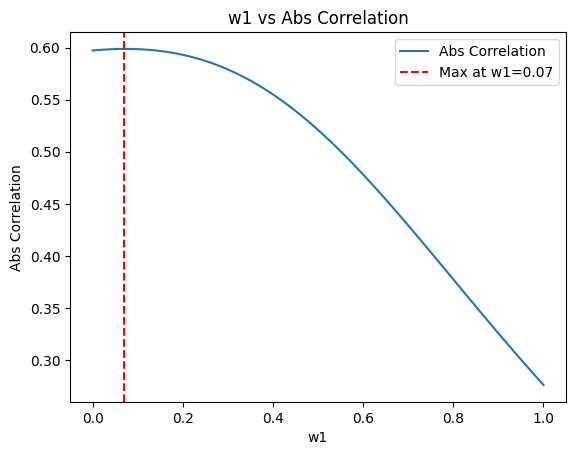

In [17]:
results = []
for w1 in np.linspace(0, 1, 101):
    w2 = 1 - w1
    weighted_sum = w1 * weekly_df['exer'] + w2 * weekly_df['food']
    abs_correlation = abs(pd.Series(weighted_sum).corr(weekly_df['y']))
    results.append({'w1': w1, 'abs_correlation': abs_correlation})

results_df = pd.DataFrame(results)

max_row = results_df.loc[results_df['abs_correlation'].idxmax()]
max_w1 = max_row['w1']
max_abs_correlation = max_row['abs_correlation']

print(f"Max abs_correlation: {max_abs_correlation} at w1: {max_w1}")

plt.plot(results_df['w1'], results_df['abs_correlation'], label='Abs Correlation')
plt.axvline(x=max_w1, color='red', linestyle='--', label=f'Max at w1={max_w1:.2f}')
plt.xlabel('w1')
plt.ylabel('Abs Correlation')
plt.title('w1 vs Abs Correlation')
plt.legend()
plt.show()

Food is more important than exercise. Again, this is data from 1 individual, it can't be used to infere in anyone else, I will probably use 0.2 and 0.8 as weights for my app. Just trying with using the optimal weight.

In [37]:
# overwritting w1 since the graph shows not much difference between optimal and 0.2.
max_w1 = 0.2

In [38]:
weekly_df['exer_food'] = max_w1 * weekly_df['exer'] + (1-max_w1) * weekly_df['food']

Intercept: 0.8955044987001476
Slope: -1.9048071730792977
R²: 0.3518497629539301


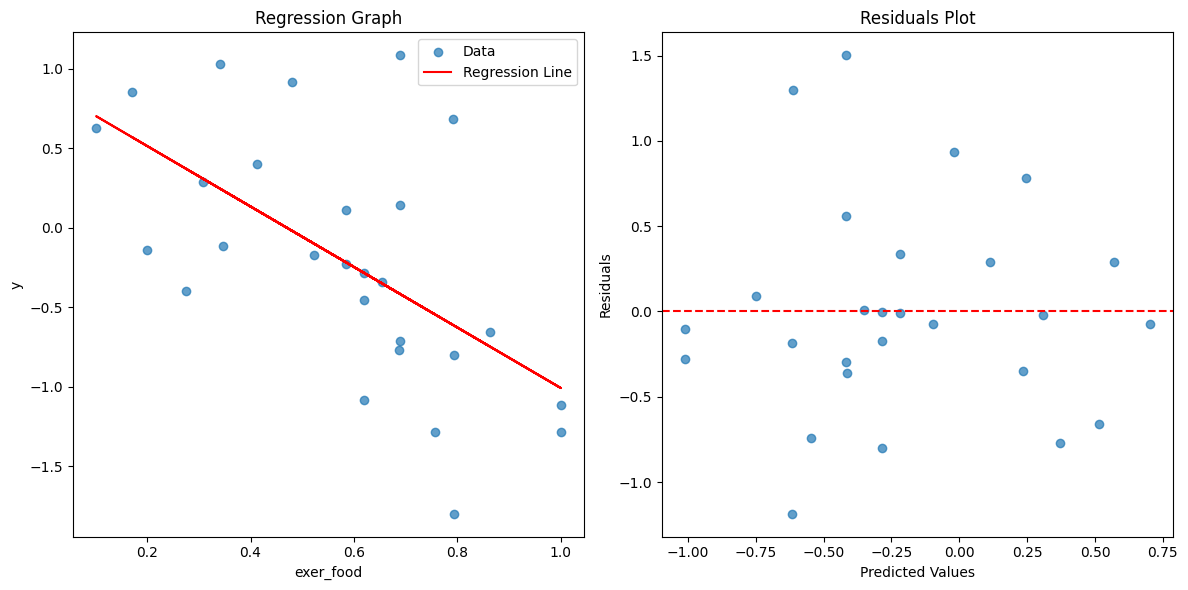

In [39]:
X = weekly_df[['exer_food']]  
y = weekly_df['y']  

model2 = LinearRegression()
model2.fit(X, y)

intercept = model2.intercept_
slope = model2.coef_[0]
r2 = r2_score(y, model2.predict(X))

print(f"Intercept: {intercept}")
print(f"Slope: {slope}")
print(f"R²: {r2}")

# Regression graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X, y, label='Data', alpha=0.7)
plt.plot(X, model2.predict(X), color='red', label='Regression Line')
plt.xlabel('exer_food')
plt.ylabel('y')
plt.title('Regression Graph')
plt.legend()

# Residuals plot
residuals = y - model2.predict(X)
plt.subplot(1, 2, 2)
plt.scatter(model2.predict(X), residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

plt.tight_layout()
plt.show()

In [40]:
model_params = {
    'slope': float(slope),
    'intercept': float(intercept),
    'food_min': float(food_min),
    'food_range': float(food_range),
    'exer_min': float(exer_min),
    'exer_range': float(exer_range),
    'w1': max_w1
}

In [41]:
model_params

{'slope': -1.9048071730792977,
 'intercept': 0.8955044987001476,
 'food_min': 2.857142857142857,
 'food_range': 3.285714285714286,
 'exer_min': 0.0,
 'exer_range': 6.0,
 'w1': 0.2}

In [42]:
with open('model_parameters_reg.json', 'w') as f:
    json.dump(model_params, f)

## Implementation

In [43]:
with open('model_parameters_reg_prod.json', 'r') as f:
    param = json.load(f)
param

{'slope': -1.9048071730792977,
 'intercept': 0.8955044987001476,
 'food_min': 2.857142857142857,
 'food_range': 3.285714285714286,
 'exer_min': 0.0,
 'exer_range': 6.0,
 'w1': 0.2}

In [44]:
last_week_food = analysis.df['food'].tail(7).mean()
last_week_exer = analysis.df['exer'].tail(7).sum()
last_week_food_n = (last_week_food - param['food_min']) / param['food_range']
last_week_exer_n = (last_week_exer - param['exer_min']) / param['exer_range']
weighted_average = param['w1']*last_week_exer_n + (1-param['w1'])*last_week_food_n
weight_gain_expected = param['intercept']+param['slope']*weighted_average
weight_gain_bad = param['intercept']+param['slope']*0.1
weight_gain_good = param['intercept']+param['slope']*0.9

In [45]:
weight_gain_expected

-0.08726557900453347

In [46]:
weight_gain_bad

0.7050237813922178

In [47]:
weight_gain_good

-0.8188219570712204

In [48]:
analysis.df

,weight_lbs,exer,food,weight_lbs_avg_7d,food_avg_7d,exer_avg_7d,food_exercise_avg_7d
date,,,,,,,
2024-11-19,160.4,1,5,NaN,NaN,NaN,NaN
2024-11-20,159.2,1,6,NaN,NaN,NaN,NaN
2024-11-21,159.0,0,5,NaN,NaN,NaN,NaN
2024-11-22,159.2,1,6,NaN,NaN,NaN,NaN
2024-11-23,159.0,0,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-05,156.6,1,4,156.457143,0.424242,0.833333,0.628788
2025-06-06,156.0,0,4,156.457143,0.424242,0.833333,0.628788
2025-06-07,154.6,0,5,156.342857,0.424242,0.666667,0.545455


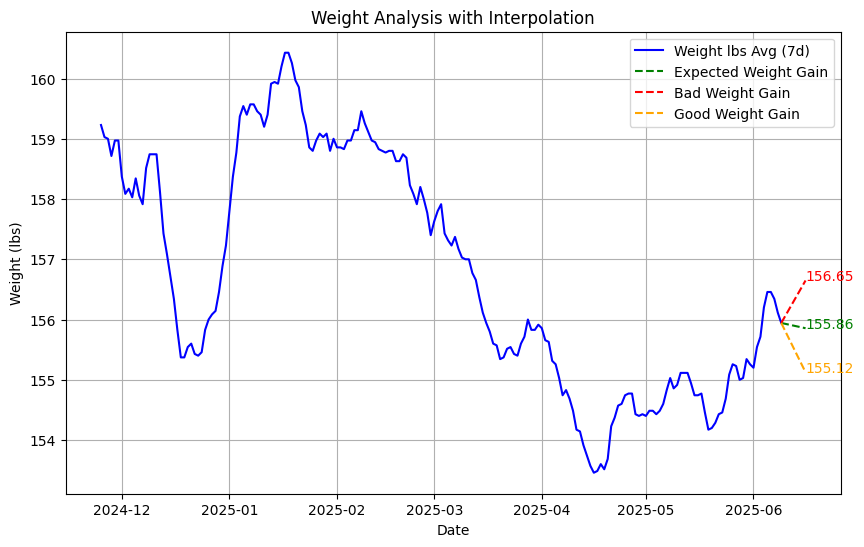

In [51]:
last_date = analysis.df.index[-1]
future_date = last_date + pd.Timedelta(days=7)

# Get the last value of the weight data
last_weight = analysis.df['weight_lbs_avg_7d'].iloc[-1]

# Calculate future weights by adding the weight gains
future_weight_expected = last_weight + weight_gain_expected
future_weight_bad = last_weight + weight_gain_bad
future_weight_good = last_weight + weight_gain_good

# Create a new DataFrame for interpolation
interpolation_df = pd.DataFrame({
    'date': [last_date, future_date],
    'weight_gain_expected': [last_weight, future_weight_expected],
    'weight_gain_bad': [last_weight, future_weight_bad],
    'weight_gain_good': [last_weight, future_weight_good]
}).set_index('date')

# Perform linear interpolation
interpolated_df = interpolation_df.resample('D').interpolate()

# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(analysis.df.index, analysis.df['weight_lbs_avg_7d'], label='Weight lbs Avg (7d)', color='blue')

# Plot interpolated values
plt.plot(interpolated_df.index, interpolated_df['weight_gain_expected'], label='Expected Weight Gain', linestyle='--', color='green')
plt.plot(interpolated_df.index, interpolated_df['weight_gain_bad'], label='Bad Weight Gain', linestyle='--', color='red')
plt.plot(interpolated_df.index, interpolated_df['weight_gain_good'], label='Good Weight Gain', linestyle='--', color='orange')

plt.text(future_date, future_weight_expected, f'{future_weight_expected:.2f}', color='green', fontsize=10, ha='left')
plt.text(future_date, future_weight_bad, f'{future_weight_bad:.2f}', color='red', fontsize=10, ha='left')
plt.text(future_date, future_weight_good, f'{future_weight_good:.2f}', color='orange', fontsize=10, ha='left')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Weight (lbs)')
plt.title('Weight Analysis with Interpolation')
plt.legend()
plt.grid(True)
plt.show()